# Downwelling plot as a function of H

In [2]:
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org
import math as M  # https://docs.python.org/2/library/math.html
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [3]:
#### Constants #####
L_x = 1000000 #zonal extent [m]
L_y = 2000000 #meridional extent [m]
A = L_x*L_y #surface area of interior [m^2] Note that the interior is probably smaller than this
P = 2*L_x+2*L_y #Perimeter [m]

g = 9.81 #gravitational acceleration [m/s^2]
C_p = 3994 #specific heat capacity of sea water [J/(kg K)] source: Steffie's paper
alpha_T = 0.2 #thermal expansion coefficient [kg m^-3 C^-1] source: Steffie's paper
alpha_S = 0.8 #Haline expansion coefficient [kg m^-3]
c = 0.006 #bottom slope coefficient
s = 0.02 #average bottom slope around the perimeter of the marginal sea
S = 35 #reference salinity [ppt]. Spall [2015]
E = -2e-8 #constant freshwater flux [m/s]
S_1 = 35.2 #from Lambert [g kg^-1]

#### Parameters ####
H = 1000 #sill height [m]
f_0 = 1.2e-4 #Coriolis parameter [s^-1]
Gamma = 20 #Restoring strength [W/(m^2 C)]

L = H/s #width of sloping topography of the boundary current [m]
T_1 = 8.87 #ingoing temperature [Celsius]
T_A = 2.8 #Atmospheric temperature [Celsius]
ro_0 = 1028  #density sea water [kg m^-3]. Range of 7 to 9 degrees of sea water
#h_1 = ... #thickness upper layer [m]

#### functions ####
epsilon = c*P/(H/s) #ratio of heat fluxed into interior by eddies compared to heat flux by advection into the basin in the inflowing boundary current [-]
mu = A*Gamma*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A)) #[-]

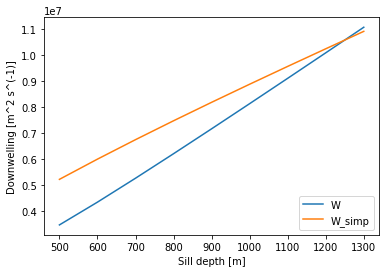

In [5]:
#Downwelling as a function of sill height
H_array = [500,600,700,800,900,1000,1100,1200,1300]

#Salinity model
T_0 = np.zeros(len(H_array))
T_2 = np.zeros(len(H_array))
S_0 = np.zeros(len(H_array))
S_2 = np.zeros(len(H_array))
Delta_T = np.zeros(len(H_array))
ro_in = np.zeros(len(H_array))
ro_out = np.zeros(len(H_array))
W = np.zeros(len(H_array))

for i in range(len(H_array)):
    H=H_array[i]
    def main(x): # function with seven unkowns:  T_0,  T_2,  S_0,  S_2,  V_1, T_eddy, S_eddy 
             #                              x[0], x[1], x[2], x[3], x[4],   x[5],   x[6]
        return [P*H*x[5]-A*Gamma*(x[0]-T_A)/(ro_0*C_p),
                P*H*x[6]+A*E*S,
                (T_1-x[1])*x[4]*H*L-(x[0] - T_A + (P*L/A)*(T_1-T_A))*A*Gamma/(ro_0*C_p),
                (S_1-x[3])*x[4]*H*L+E*A*S+P*L*E*S,
                g*H/(2*ro_0*f_0*L)*(alpha_T*(T_1-x[0])-alpha_S*(S_1-x[2]))-x[4],
                c*x[4]*(T_1-x[0])-x[5],
                c*x[4]*(S_1-x[2])-x[6]]
    [T_0[i],T_2[i],S_0[i],S_2[i],V_1,T_eddy,S_eddy] = fsolve(main, [1,1,1,1,1,1,1])
    ro_in[i] = ro_0+((alpha_T*(T_1-T_0[i]) - alpha_S*(S_1-S_0[i])))
    ro_out[i] = ro_0+(alpha_T*(T_2[i]-T_0[i]) - alpha_S*(S_2[i]-S_0[i]))
    W[i] = g*M.pow(H,2)*(ro_in[i] - ro_out[i])/(4*ro_0*f_0)
    
#Simple model
T_0_simp = np.zeros(len(H_array))
T_out_simp = np.zeros(len(H_array))
W_simp = np.zeros(len(H_array))

for i in range(len(H_array)):
    T_0_simp[i] = T_1 - ((A*Gamma*f_0/(alpha_T*g*C_p*H_array[i]**2*(T_1-T_A)))/(c*P/(H_array[i]/s)))*(M.sqrt(1+2*(c*P/(H_array[i]/s))/(A*Gamma*f_0/(alpha_T*g*C_p*H_array[i]**2*(T_1-T_A))))-1)*(T_1 - T_A)
    T_out_simp[i] = T_1 - 2*(A*Gamma*f_0/(alpha_T*g*C_p*H_array[i]**2*(T_1-T_A)))*((T_1-T_A)/(T_1-T_0_simp[i])*(1+P*(H_array[i]/s)/A)-1)*(T_1-T_A)
    W_simp[i] = alpha_T*g*H_array[i]**2*(T_1-T_0_simp[i])/(4*ro_0*f_0)*(1-(T_out_simp[i]-T_0_simp[i])/(T_1-T_0_simp[i]))
    
#Plots
plt.figure()
plt.plot(H_array,W,label='W')
plt.plot(H_array, W_simp, label='W_simp')
plt.xlabel('Sill depth [m]') # label along x-axes
plt.ylabel('Downwelling [m^2 s^(-1)]')
plt.legend(loc='lower right')
plt.show()

Downwelling increases as a function of sill height. This is in accordance with table 1 in Spall. More water flux, results in more ....